## Excercise: Build a weighted Nearest Neighbor model using visual,brand,text and color?

In [4]:
from PIL import Image #support for opening,manipulating,saving any different file format
import requests #deals with url's
from io import BytesIO #data can be kept as in-memory buffer which is faster
import matplotlib.pyplot as plt #for graphs and visualization
import numpy as np #for numerical computation
import pandas as pd #for data manipulation
import warnings #to avoid errors
from bs4 import BeautifulSoup #for webscrapping
from nltk.corpus import stopwords #to avoid stopwords
from nltk.tokenize import word_tokenize #splits text into words
import nltk #natural language toolkit library
import math #for math operations
import time #for printing excution time 
import re #delas with regular expression
import os #for reading and writing to system
import seaborn as sns #for effective visualisation
from collections import Counter #counter
from sklearn.feature_extraction.text import CountVectorizer #extract text features and count frequency
from sklearn.feature_extraction.text import TfidfVectorizer #tf-idf transformer
from sklearn.metrics.pairwise import cosine_similarity #computes similarity with dot product of X and Y 
from sklearn.metrics import pairwise_distances #computes distance matrice
from matplotlib import gridspec #specifies geometry of gird that a subplot will be placed
from scipy.sparse import hstack #horizontal stack sparse matrix horizontally
import plotly #for 3d visualization
import plotly.figure_factory as ff #wrapper function contains unique chart types
from plotly.graph_objs import Scatter, Layout #defines size and layout

plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")

In [5]:
#after removing duplicates and stop words we got 16k_apparel_data_preprocessed pickle file
data = pd.read_pickle('pickels/16k_apperal_data_preprocessed')
data.head()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies long sleeve stain resistant...,$26.26
6,B012YX2ZPI,HX-Kingdom Fashion T-shirts,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,womens unique 100 cotton special olympics wor...,$9.99
15,B003BSRPB0,FeatherLite,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies moisture free mesh sport sh...,$20.54
27,B014ICEJ1Q,FNC7C,Purple,https://images-na.ssl-images-amazon.com/images...,SHIRT,supernatural chibis sam dean castiel neck tshi...,$7.39
46,B01NACPBG2,Fifth Degree,Black,https://images-na.ssl-images-amazon.com/images...,SHIRT,fifth degree womens gold foil graphic tees jun...,$6.95


In [6]:
idf_title_vectorizer = CountVectorizer()
idf_title_features = idf_title_vectorizer.fit_transform(data['title'])

In [7]:
def n_containing(word):
    # return the number of documents which had the given word
    return sum(1 for blob in data['title'] if word in blob.split())

def idf(word):
    # idf = log(#number of docs / #number of docs which had the given word)
    return math.log(data.shape[0] / (n_containing(word)))

In [8]:
# we need to convert the values into float
idf_title_features  = idf_title_features.astype(np.float)

for i in idf_title_vectorizer.vocabulary_.keys():
    # for every word in whole corpus we will find its idf value
    idf_val = idf(i)
    
    # to calculate idf_title_features we need to replace the count values with the idf values of the word
    # idf_title_features[:, idf_title_vectorizer.vocabulary_[i]].nonzero()[0] will return all documents in which the word i present
    for j in idf_title_features[:, idf_title_vectorizer.vocabulary_[i]].nonzero()[0]:
        
        # we replace the count values of word i in document j with  idf_value of word i 
        # idf_title_features[doc_id, index_of_word_in_courpus] = idf value of word
        idf_title_features[j,idf_title_vectorizer.vocabulary_[i]] = idf_val

In [9]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
with open('word2vec_model', 'rb') as handle:
    model = pickle.load(handle)

In [10]:
# vocab = stores all the words that are there in google w2v model
# vocab = model.wv.vocab.keys() # if you are using Google word2Vec

vocab = model.keys()
# this function will add the vectors of each word and returns the avg vector of given sentance
def build_avg_vec(sentence, num_features, doc_id, m_name):
    # sentace: its title of the apparel
    # num_features: the lenght of word2vec vector, its values = 300
    # m_name: model information it will take two values
        # if  m_name == 'avg', we will append the model[i], w2v representation of word i
        # if m_name == 'weighted', we will multiply each w2v[word] with the idf(word)

    featureVec = np.zeros((num_features,), dtype="float32")
    # we will intialize a vector of size 300 with all zeros
    # we add each word2vec(wordi) to this fetureVec
    nwords = 0
    
    for word in sentence.split():
        nwords += 1
        if word in vocab:
            if m_name == 'weighted' and word in  idf_title_vectorizer.vocabulary_:
                featureVec = np.add(featureVec, idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[word]] * model[word])
            elif m_name == 'avg':
                featureVec = np.add(featureVec, model[word])
    if(nwords>0):
        featureVec = np.divide(featureVec, nwords)
    # returns the avg vector of given sentance, its of shape (1, 300)
    return featureVec


In [11]:
doc_id = 0
w2v_title_weight = []
# for every title we build a weighted vector representation
for i in data['title']:
    w2v_title_weight.append(build_avg_vec(i, 300, doc_id,'weighted'))
    doc_id += 1
# w2v_title = np.array(# number of doc in courpus * 300), each row corresponds to a doc 
w2v_title_weight = np.array(w2v_title_weight)

In [12]:
import numpy as np #numerical computation
from keras.preprocessing.image import ImageDataGenerator#processing image
from keras.models import Sequential #creating sequential model
from keras.layers import Dropout, Flatten, Dense #sequential model with droput,flatten,and Dense layouts
from keras import applications #to use pretrained models on imagenet
from sklearn.metrics import pairwise_distances #for distance
import matplotlib.pyplot as plt #for visualization
import requests #for url dealing
from PIL import Image #for image manipulating, saving diff formats
import pandas as pd # for data processing
import pickle #for faster loading

Using TensorFlow backend.


In [13]:
#load the features and corresponding ASINS info.
bottleneck_features_train = np.load('16k_data_cnn_features.npy')
asins = np.load('16k_data_cnn_feature_asins.npy')
asins = list(asins)

# load the original 16K dataset
data = pd.read_pickle('pickels/16k_apperal_data_preprocessed')
df_asins = list(data['asin'])

from IPython.display import display, Image, SVG, Math, YouTubeVideo

In [14]:
# some of the brand values are empty. 
# Need to replace Null with string "NULL"
data['brand'].fillna(value="Not given", inplace=True )

# replace spaces with hypen
brands = [x.replace(" ", "-") for x in data['brand'].values]
types = [x.replace(" ", "-") for x in data['product_type_name'].values]
colors = [x.replace(" ", "-") for x in data['color'].values]

brand_vectorizer = CountVectorizer()
brand_features = brand_vectorizer.fit_transform(brands)

type_vectorizer = CountVectorizer()
type_features = type_vectorizer.fit_transform(types)

color_vectorizer = CountVectorizer()
color_features = color_vectorizer.fit_transform(colors)

extra_features = hstack((brand_features, type_features, color_features)).tocsr()

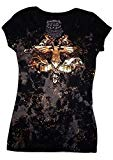

Product Title:  fifth degree womens gold foil graphic tees junior top short sleeve printed shirt  l 
Euclidean Distance from input image: 3.977887420100486
Amazon Url: www.amzon.com/dp/B01NACPBG2


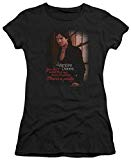

Product Title:  juniors vampire diaries  threes party juniors slim tshirt size l 
Euclidean Distance from input image: 15.642939289967494
Amazon Url: www.amzon.com/dp/B00IAAFXB8


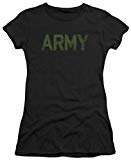

Product Title:  juniors army  type juniors slim tshirt size xl 
Euclidean Distance from input image: 16.004749084075566
Amazon Url: www.amzon.com/dp/B00XCXG24U


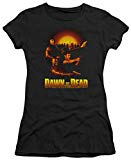

Product Title:  juniors dawn dead  dawn collage juniors slim tshirt size l 
Euclidean Distance from input image: 16.127595011634146
Amazon Url: www.amzon.com/dp/B00IAAT6AW


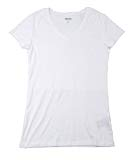

Product Title:  kirkland signature ladies size medium cotton vneck tee white 
Euclidean Distance from input image: 16.19614283255861
Amazon Url: www.amzon.com/dp/B073ZRD5FL


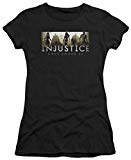

Product Title:  juniors injustice gods among us  logo juniors slim tshirt size xxl 
Euclidean Distance from input image: 16.41968158936528
Amazon Url: www.amzon.com/dp/B00IABTNOA


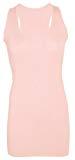

Product Title:  funky boutique womens sleeveless racer back muscle vest 810 sm nude 
Euclidean Distance from input image: 16.435762023925783
Amazon Url: www.amzon.com/dp/B00HW0HAP4


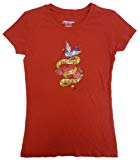

Product Title:  greensource womens born lucky tee regal red xxl 
Euclidean Distance from input image: 16.461862437171256
Amazon Url: www.amzon.com/dp/B00BGEM4QC


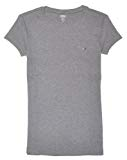

Product Title:  tommy hilfiger women slim fit crewneck logo tshirt xxl dark grey 
Euclidean Distance from input image: 16.594748179358756
Amazon Url: www.amzon.com/dp/B00B5FD7J0


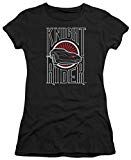

Product Title:  juniors knight rider  logo juniors slim tshirt size l 
Euclidean Distance from input image: 16.59568837483724
Amazon Url: www.amzon.com/dp/B00IABLRYO


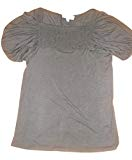

Product Title:  vivienne tam black blouse top size xs 
Euclidean Distance from input image: 16.647571858326867
Amazon Url: www.amzon.com/dp/B01EXP65XI


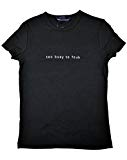

Product Title:  french connection black busy fcuk short sleeve tshirt xs xsmall 
Euclidean Distance from input image: 16.662836499530115
Amazon Url: www.amzon.com/dp/B01BUI92SG


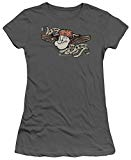

Product Title:  juniors popeye  yam juniors slim tshirt size l 
Euclidean Distance from input image: 16.701837667070343
Amazon Url: www.amzon.com/dp/B00IAAC2C6


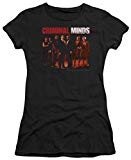

Product Title:  juniors criminal minds  crew juniors slim tshirt size 
Euclidean Distance from input image: 16.708326721432325
Amazon Url: www.amzon.com/dp/B00DEHOELW


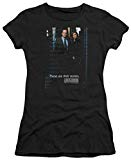

Product Title:  juniors law  order svu juniors slim tshirt size xl 
Euclidean Distance from input image: 16.729017893714225
Amazon Url: www.amzon.com/dp/B00IAAGUJC


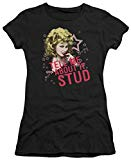

Product Title:  juniors grease  tell stud juniors slim tshirt size xxl 
Euclidean Distance from input image: 16.729263600270226
Amazon Url: www.amzon.com/dp/B00IQYQ7LS


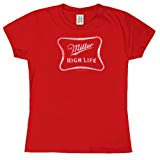

Product Title:  miller  high life juniors tshirt  large 
Euclidean Distance from input image: 16.795723978919302
Amazon Url: www.amzon.com/dp/B001GPK8G4


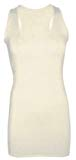

Product Title:  funky boutique womens sleeveless racer back muscle vest  810 sm cream 
Euclidean Distance from input image: 16.857227365732466
Amazon Url: www.amzon.com/dp/B00FXRN3KO


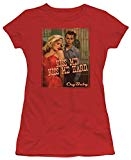

Product Title:  juniors cry baby  kiss juniors slim tshirt size xl 
Euclidean Distance from input image: 17.00546497559575
Amazon Url: www.amzon.com/dp/B00IAAF85E


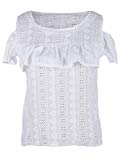

Product Title:  anna kaci sm fit classic white shoulder bare short sleeve peplum flare blouse 
Euclidean Distance from input image: 17.04981566325851
Amazon Url: www.amzon.com/dp/B010EH3B8Q


In [15]:
def predicter(doc_id,document_id, w1, w2,w3, num_results):
    # doc_id: apparel's id in given corpus
    # w1: weight for  w2v features
    # w2: weight for brand and color features

    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    idf_w2v_dist  = pairwise_distances(w2v_title_weight, w2v_title_weight[doc_id].reshape(1,-1))
    
    ex_feat_dist = pairwise_distances(extra_features, extra_features[doc_id])
    
    document_id = asins.index(df_asins[document_id])
    imge_dist = pairwise_distances(bottleneck_features_train, bottleneck_features_train[document_id].reshape(1,-1))

    
    pairwise_dist   = (w1 * idf_w2v_dist +  w2 * ex_feat_dist + w3 * imge_dist)/float(w1 + w2 + w3)

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])
    

    for i in range(len(indices)):
        rows = data[['medium_image_url','title']].loc[data['asin']==asins[indices[i]]]
        for indx, row in rows.iterrows():
            display(Image(url=row['medium_image_url'], embed=True))
            print('Product Title: ', row['title'])
            print('Euclidean Distance from input image:', pdists[i])
            print('Amazon Url: www.amzon.com/dp/'+ asins[indices[i]])
            print('='*125)

predicter(12566,4,5, 5, 5, 20)
# in the give heat map, each cell contains the euclidean distance between words i, j

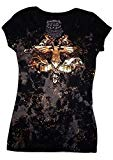

Product Title:  fifth degree womens gold foil graphic tees junior top short sleeve printed shirt  l 
Euclidean Distance from input image: 1.9020425394841702
Amazon Url: www.amzon.com/dp/B01NACPBG2


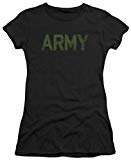

Product Title:  juniors army  type juniors slim tshirt size xl 
Euclidean Distance from input image: 20.161305335897165
Amazon Url: www.amzon.com/dp/B00XCXG24U


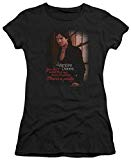

Product Title:  juniors vampire diaries  threes party juniors slim tshirt size l 
Euclidean Distance from input image: 20.428764564216344
Amazon Url: www.amzon.com/dp/B00IAAFXB8


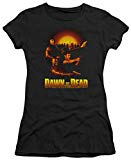

Product Title:  juniors dawn dead  dawn collage juniors slim tshirt size l 
Euclidean Distance from input image: 20.780264319545893
Amazon Url: www.amzon.com/dp/B00IAAT6AW


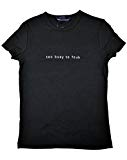

Product Title:  french connection black busy fcuk short sleeve tshirt xs xsmall 
Euclidean Distance from input image: 21.079213765906022
Amazon Url: www.amzon.com/dp/B01BUI92SG


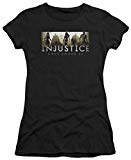

Product Title:  juniors injustice gods among us  logo juniors slim tshirt size xxl 
Euclidean Distance from input image: 21.12043667210932
Amazon Url: www.amzon.com/dp/B00IABTNOA


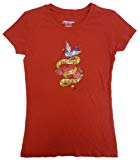

Product Title:  greensource womens born lucky tee regal red xxl 
Euclidean Distance from input image: 21.120531882412102
Amazon Url: www.amzon.com/dp/B00BGEM4QC


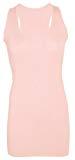

Product Title:  funky boutique womens sleeveless racer back muscle vest 810 sm nude 
Euclidean Distance from input image: 21.123177749335973
Amazon Url: www.amzon.com/dp/B00HW0HAP4


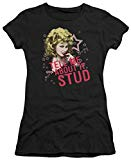

Product Title:  juniors grease  tell stud juniors slim tshirt size xxl 
Euclidean Distance from input image: 21.139391044515328
Amazon Url: www.amzon.com/dp/B00IQYQ7LS


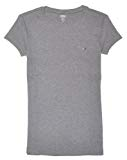

Product Title:  tommy hilfiger women slim fit crewneck logo tshirt xxl dark grey 
Euclidean Distance from input image: 21.202018584377434
Amazon Url: www.amzon.com/dp/B00B5FD7J0


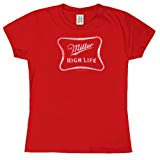

Product Title:  miller  high life juniors tshirt  large 
Euclidean Distance from input image: 21.274113978511956
Amazon Url: www.amzon.com/dp/B001GPK8G4


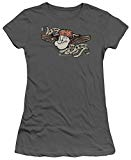

Product Title:  juniors popeye  yam juniors slim tshirt size l 
Euclidean Distance from input image: 21.36597045815673
Amazon Url: www.amzon.com/dp/B00IAAC2C6


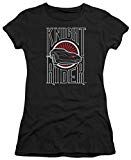

Product Title:  juniors knight rider  logo juniors slim tshirt size l 
Euclidean Distance from input image: 21.403942775726318
Amazon Url: www.amzon.com/dp/B00IABLRYO


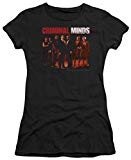

Product Title:  juniors criminal minds  crew juniors slim tshirt size 
Euclidean Distance from input image: 21.447344912655023
Amazon Url: www.amzon.com/dp/B00DEHOELW


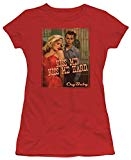

Product Title:  juniors cry baby  kiss juniors slim tshirt size xl 
Euclidean Distance from input image: 21.509059432882026
Amazon Url: www.amzon.com/dp/B00IAAF85E


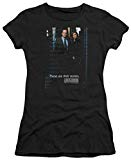

Product Title:  juniors law  order svu juniors slim tshirt size xl 
Euclidean Distance from input image: 21.604707945949702
Amazon Url: www.amzon.com/dp/B00IAAGUJC


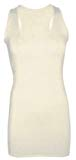

Product Title:  funky boutique womens sleeveless racer back muscle vest  810 sm cream 
Euclidean Distance from input image: 21.63187592667362
Amazon Url: www.amzon.com/dp/B00FXRN3KO


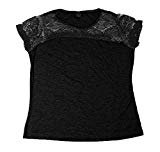

Product Title:  women slim lace carved patchwork tshirt tops tees shirt l  us black 
Euclidean Distance from input image: 21.735859908229976
Amazon Url: www.amzon.com/dp/B00MBARBLS


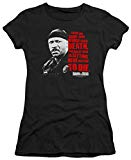

Product Title:  juniors dawn dead  worse death juniors slim tshirt size l 
Euclidean Distance from input image: 21.766544760830072
Amazon Url: www.amzon.com/dp/B00IAABMZO


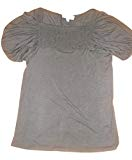

Product Title:  vivienne tam black blouse top size xs 
Euclidean Distance from input image: 21.81159744634028
Amazon Url: www.amzon.com/dp/B01EXP65XI


In [26]:
predicter(12579, 4,5, 5, 10, 20)

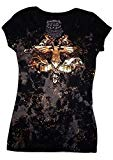

Product Title:  fifth degree womens gold foil graphic tees junior top short sleeve printed shirt  l 
Euclidean Distance from input image: 2.2744683527946474
Amazon Url: www.amzon.com/dp/B01NACPBG2


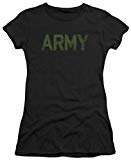

Product Title:  juniors army  type juniors slim tshirt size xl 
Euclidean Distance from input image: 9.50281517920007
Amazon Url: www.amzon.com/dp/B00XCXG24U


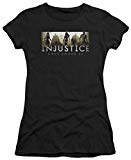

Product Title:  juniors injustice gods among us  logo juniors slim tshirt size xxl 
Euclidean Distance from input image: 9.919854134888546
Amazon Url: www.amzon.com/dp/B00IABTNOA


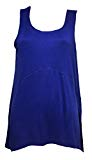

Product Title:  pink rose juniors sideslit handkerchie pop royal xs 
Euclidean Distance from input image: 9.99155876159668
Amazon Url: www.amzon.com/dp/B071L4XNDG


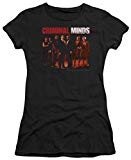

Product Title:  juniors criminal minds  crew juniors slim tshirt size 
Euclidean Distance from input image: 10.005759672085922
Amazon Url: www.amzon.com/dp/B00DEHOELW


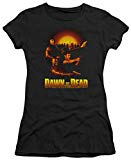

Product Title:  juniors dawn dead  dawn collage juniors slim tshirt size l 
Euclidean Distance from input image: 10.007570203702134
Amazon Url: www.amzon.com/dp/B00IAAT6AW


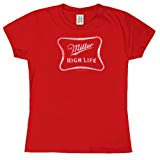

Product Title:  miller  high life juniors tshirt  large 
Euclidean Distance from input image: 10.013899015347642
Amazon Url: www.amzon.com/dp/B001GPK8G4


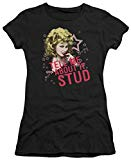

Product Title:  juniors grease  tell stud juniors slim tshirt size xxl 
Euclidean Distance from input image: 10.119246529908077
Amazon Url: www.amzon.com/dp/B00IQYQ7LS


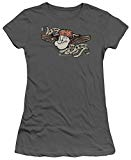

Product Title:  juniors popeye  yam juniors slim tshirt size l 
Euclidean Distance from input image: 10.144632963101548
Amazon Url: www.amzon.com/dp/B00IAAC2C6


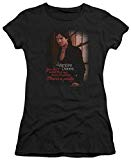

Product Title:  juniors vampire diaries  threes party juniors slim tshirt size l 
Euclidean Distance from input image: 10.165807415056724
Amazon Url: www.amzon.com/dp/B00IAAFXB8


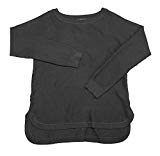

Product Title:  cyrus ladies small ribbed texture pullover tunic sweater black 
Euclidean Distance from input image: 10.178588928755193
Amazon Url: www.amzon.com/dp/B06XN6R331


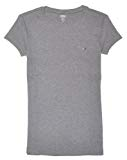

Product Title:  tommy hilfiger women slim fit crewneck logo tshirt xxl dark grey 
Euclidean Distance from input image: 10.190612272183579
Amazon Url: www.amzon.com/dp/B00B5FD7J0


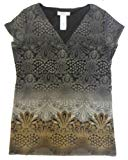

Product Title:  lizwear liz claiborne womens short sleeve mesh printed top blackbrown small 
Euclidean Distance from input image: 10.200372323365109
Amazon Url: www.amzon.com/dp/B00A2SRY5O


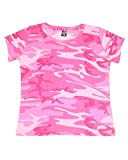

Product Title:  code v womens fine jersey camo tee shirt xl pink woodland 
Euclidean Distance from input image: 10.223094415039913
Amazon Url: www.amzon.com/dp/B001JC47RA


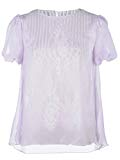

Product Title:  anna kaci sm fit classic purple balloon sleeve slit back intricate design top 
Euclidean Distance from input image: 10.24278328833093
Amazon Url: www.amzon.com/dp/B010EH3YHY


In [21]:
predicter(15676,4,5, 15, 5, 15) #recommend only 15 with different weights

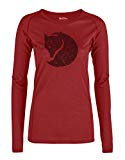

Product Title:  fjallraven  womens abisko trail tshirt printed longsleeve lava xxs 
Euclidean Distance from input image: 1.6390311958573898
Amazon Url: www.amzon.com/dp/B073WLKVN9


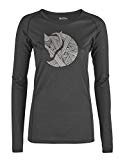

Product Title:  fjallraven  womens abisko trail tshirt printed longsleeve dark grey xxs 
Euclidean Distance from input image: 7.739531475115317
Amazon Url: www.amzon.com/dp/B073WL6NH1


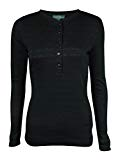

Product Title:  lrl lauren jeans co womens metallic striped knit henley xs black 
Euclidean Distance from input image: 8.464552597578436
Amazon Url: www.amzon.com/dp/B01AGSCRUG


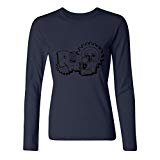

Product Title:  womens robot friday logo long sleeve tshirt 
Euclidean Distance from input image: 8.694768380494015
Amazon Url: www.amzon.com/dp/B01KLR83A0


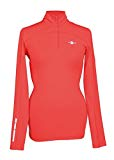

Product Title:  shires ladies base layer top xlarge red 
Euclidean Distance from input image: 9.041601037354367
Amazon Url: www.amzon.com/dp/B06XRDVT37


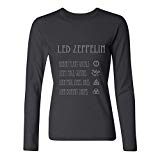

Product Title:  yatyler customized led zeppelin bluesrock longsleeved tee shirts ladies black 
Euclidean Distance from input image: 9.114697579712765
Amazon Url: www.amzon.com/dp/B019IEU3T6


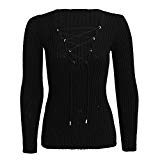

Product Title:  pikolai women casual long sleeve knitted bandage sweaters tshirt blouse xl black 
Euclidean Distance from input image: 9.144088605801743
Amazon Url: www.amzon.com/dp/B01LZ2B1HT


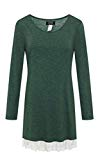

Product Title:  zshow womens long sleeve casual loose tunic tops girlsarmy greenmedium 
Euclidean Distance from input image: 9.191529626221554
Amazon Url: www.amzon.com/dp/B071NTKYPG


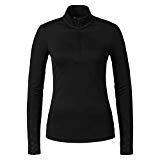

Product Title:  kjus ladies feel printed halfzip 2017 black 38 
Euclidean Distance from input image: 9.19636826888768
Amazon Url: www.amzon.com/dp/B01M3V3AJJ


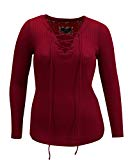

Product Title:  pluspice womens sexy lace softest ribbed top plussize 1xl deep red 
Euclidean Distance from input image: 9.245653699795884
Amazon Url: www.amzon.com/dp/B01N0OF80D


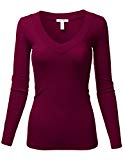

Product Title:  basic fitted sexy knit long sleeve vneck tee tops 
Euclidean Distance from input image: 9.247273191373033
Amazon Url: www.amzon.com/dp/B01A9G8NPS


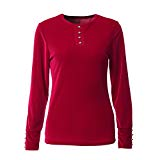

Product Title:  sodialr womens fashion long sleeve velvet topsredxlus12 
Euclidean Distance from input image: 9.28825966772546
Amazon Url: www.amzon.com/dp/B06XC25J1T


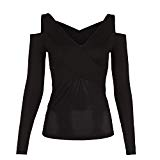

Product Title:  michi womens siren top black xsmall 
Euclidean Distance from input image: 9.300004896084946
Amazon Url: www.amzon.com/dp/B01LW6Q6EG


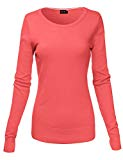

Product Title:  basic crew neck long sleeve soft sweater knit tops 
Euclidean Distance from input image: 9.313914574952022
Amazon Url: www.amzon.com/dp/B01MG94GU9


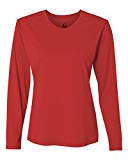

Product Title:  badger sport womens c2 long sleeve tee shirt large red 
Euclidean Distance from input image: 9.480796293179672
Amazon Url: www.amzon.com/dp/B00R2TUDCM


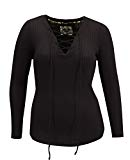

Product Title:  pluspice womens lattice front long sleeve ribbed knit top red 1x 
Euclidean Distance from input image: 9.520654386441391
Amazon Url: www.amzon.com/dp/B01MSWP4C9


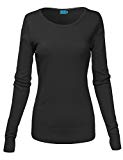

Product Title:  basic crew neck long sleeve soft sweater knit tops 012black us xl 
Euclidean Distance from input image: 9.61020860091893
Amazon Url: www.amzon.com/dp/B01J4RDGYQ


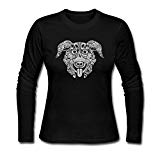

Product Title:  xiaohuang86 women shirts casual good 
Euclidean Distance from input image: 9.62559808150975
Amazon Url: www.amzon.com/dp/B01M24XN6J


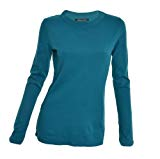

Product Title:  central park west rich color tshirt teal small 
Euclidean Distance from input image: 9.640960935513657
Amazon Url: www.amzon.com/dp/B00JX10QEW


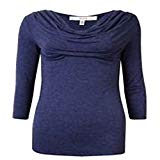

Product Title:  studio womens blue jersey draped hem long sleeves casual top shirt 
Euclidean Distance from input image: 9.666941219378012
Amazon Url: www.amzon.com/dp/B01M05593J


In [24]:
predicter(15676,33,5, 15, 5, 20)